# MODEL RUN

In [21]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
from transformers import BloomForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m", add_prefix_space=True)

# model = BloomForCausalLM.from_pretrained("bigscience/bloom-560m-intermediate", revision='global_step10000')


In [2]:
import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from torch import nn
import torch


def compute_loss_labelsmoothed(logits, labels, ignore_index=-100, epsilon=0.1):
    logits = logits[..., :-1, :].contiguous()
    labels = labels[..., 1:].contiguous()

    log_probs = -nn.functional.log_softmax(logits, dim=-1)
    if labels.dim() == log_probs.dim() - 1:
        labels = labels.unsqueeze(-1)

    padding_mask = labels.eq(ignore_index)

    labels = torch.clamp(labels, min=0)
    nll_loss = log_probs.gather(dim=-1, index=labels)

    smoothed_loss = log_probs.sum(dim=-1, keepdim=True, dtype=torch.float32)

    nll_loss.masked_fill_(padding_mask, 0.0)
    smoothed_loss.masked_fill_(padding_mask, 0.0)

    num_active_elements = padding_mask.numel() - padding_mask.long().sum()
    nll_loss = nll_loss.sum() / num_active_elements
    smoothed_loss = smoothed_loss.sum() / (num_active_elements * log_probs.shape[-1])
    return (1 - epsilon) * nll_loss + epsilon * smoothed_loss

    
class MyNet(nn.Module): #t5 сложнее создавать создавать датасет для лм так как много пришлось бы возиться с префиксами
    def __init__(self, revision, layers):
        super().__init__()
#         self.transformer = GPT2LMHeadModel.from_pretrained('gpt2')
        self.transformer = BloomForCausalLM.from_pretrained(
            "bigscience/bloom-560m-intermediate",
            revision=revision,
        )
        
        hid_size = self.transformer.config.hidden_size
        self.voc_size = self.transformer.config.vocab_size
        
        self.early_exits = nn.ModuleList([
            nn.Linear(hid_size, self.voc_size) for _ in layers
        ])
        self._hidden_indices = layers
        print(f'will be using outputs of {self._hidden_indices} layers')
        self.ce = nn.CrossEntropyLoss()
    
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            output_hidden_states=True,
        )
        
        hidden_states = output.hidden_states[1:-1]
        heads_outputs = [
            self.early_exits[idx](hidden_states[self._hidden_indices[idx]]) 
            for idx in range(0, len(self.early_exits))
        ]
                
        if labels is None:
            heads_outputs = [
                torch.softmax(head_output, dim=-1) for head_output in heads_outputs
            ] # h_os[i][bs][seqlen][tok_num] = P(из i-го слоя на seqlen месте стоит токен tok_num)

            return {'head_outputs': heads_outputs, 'last_head': torch.softmax(output.logits, dim=-1)}
                
        losses = [
            compute_loss_labelsmoothed(head_output, labels)
            for head_output in heads_outputs
        ]
        
        losses = torch.stack(losses,)
        total_loss = torch.sum(losses)
        
        heads_outputs = [
            torch.softmax(head_output, dim=-1).detach() for head_output in heads_outputs
        ] # h_os[i][bs][seqlen][tok_num] = P(из i-го слоя на seqlen месте стоит токен tok_num)

        return {
            'loss': total_loss, 
            'head_outputs': heads_outputs,  # [num_layers, bs=1, seq_len, vocab_size] # {token: {layer_num: [probabilities, ... ]}}
            'last_head': torch.softmax(output.logits, dim=-1).detach(),
        }
        

In [4]:
from transformers import DataCollatorForLanguageModeling

collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

net = MyNet("global_step100000", [3, 14, 21]).to('cuda')
net = net.eval()

from transformers import Trainer

net.load_state_dict(torch.load('../mnt/bloom-models/bloom-final-global-step-100000/pytorch_model.bin'))

net.eval();

will be using outputs of [3, 14, 21] layers


### получаем тестовый датасет

In [9]:
dataset_path = 'files/dataset_test'
dataset_cache = 'files/.cache'

In [10]:
from datasets import load_dataset
import numpy as np

# dataset = load_dataset("wikipedia", "20220301.en", dataset_cache)

# rand_idx = np.random.choice(np.arange(len(dataset['train'])), size=100_000, replace=False)

# # import json
# # rand_idx = json.load(open('indices.json', 'r'))

# dataset = dataset['train'].select(rand_idx, )

# # # import json

# # # json.dump(rand_idx.tolist(), open('indices.json', 'w'),)

# # def tokenize_data(example):
# #     return tokenizer(example['text'], max_length=512, truncation=True)

# # dataset = dataset.map(
# #     tokenize_data, remove_columns=['text', 'id', 'url', 'title'], batched=True, num_proc=10
# # )

# dataset.save_to_disk(dataset_path)


from datasets import load_from_disk

dataset = load_from_disk(dataset_path)

In [11]:
dataset

Dataset({
    features: ['id', 'url', 'title', 'text'],
    num_rows: 100000
})

In [16]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [17]:
from collections import defaultdict

In [18]:
@torch.inference_mode()
def get_sentence_probs(sent):
    words = sent.lower().split()
    
    tokenized = tokenizer(
        words, truncation=True, max_length=512, is_split_into_words=True, return_tensors='pt'
    ).to('cuda')
    
    outputs = net(**tokenized)
    
    heads_probs = outputs['head_outputs'] + [outputs['last_head']]
    heads_probs = torch.stack(heads_probs)  # [num_layers, 1, seq_len, voc_size]
    
    return_dict = defaultdict(lambda: defaultdict(list))
    
    word_ids = tokenized.word_ids()
    
    heads_preds_per_words = []
    for i in range(len(word_ids) - 1):
        word_id = word_ids[i + 1]
                
        gt_token_id = tokenized['input_ids'][0, i + 1]
        heads_predictions = heads_probs[:, 0, i, gt_token_id].cpu().numpy()
        
        heads_preds_per_words.append(heads_predictions)
    
    prev_word_id = 0
    cur_prob = np.zeros(*heads_preds_per_words[0].shape) # [num_layers, ]
    cur_count = 0
    
    for i in range(len(word_ids) - 1):
        word_id = word_ids[i + 1]
        heads_prediction = heads_preds_per_words[i] # [num_layers, ]
        
        if word_id == prev_word_id:
            cur_count += 1
            for layer in range(len(heads_prediction)):
                cur_prob[layer] += heads_prediction[layer]
        else:
        
            word_key = lemmatizer.lemmatize(words[word_id])

            for layer in range(len(heads_predictions)):
                return_dict[word_key][layer].append(cur_prob[layer] / cur_count)
            
            cur_prob = heads_prediction
            cur_count = 1
            
    for k, v in return_dict.items():
        for kv, arrs in v.items():
            return_dict[k][kv] = np.mean(np.stack(arrs), axis=0)
            
    return return_dict
    # {word: {layer: [probs, ...]}}

In [26]:
from tqdm.auto import tqdm
import joblib

In [28]:
for model_path, name in zip([
    '../mnt/bloom-models/bloom-final-global-step-100000/pytorch_model.bin',
     '../mnt/bloom-models/bloom-final-global-step-300000/pytorch_model.bin',
     '../mnt/bloom-models/bloom-final-global-step-600000/pytorch_model.bin',
     '../mnt/bloom-models/bloom-10000/checkpoint-91000/pytorch_model.bin',
], ['bloom-100000', 'bloom-300000', 'bloom-600000', 'bloom-10000']):
    del net
    torch.cuda.empty_cache()
    
    net = MyNet("global_step100000", [3, 14, 21]).to('cuda')
    net.load_state_dict(torch.load(model_path))
    net.eval()

    word_stats = defaultdict(lambda: defaultdict(list))

    for i in tqdm(range(10_000)):
        example = dataset[i]

        return_dict = get_sentence_probs(example['text'])

        for word in return_dict.keys():
            for layer in return_dict[word].keys():
                word_stats[word][layer].append(return_dict[word][layer])

    word_stats_dict = {k: dict(v) for k, v in word_stats.items()}
    joblib.dump(word_stats_dict, f'../mnt/{name}.joblib')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



will be using outputs of [3, 14, 21] layers


  0%|          | 0/10000 [00:00<?, ?it/s]

will be using outputs of [3, 14, 21] layers


  0%|          | 0/10000 [00:00<?, ?it/s]

will be using outputs of [3, 14, 21] layers


  0%|          | 0/10000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
# import joblib

# word_stats_dict = {k: dict(v) for k, v in word_stats.items()}
# joblib.dump(word_stats_dict, 'files/word_stats_dict.joblib')

_______

# ANALYSE

In [3]:
import joblib
import matplotlib.pyplot as plt
import numpy as np

In [4]:
word_stats_10000 = joblib.load('../mnt/bloom-10000.joblib')
word_stats_100000 = joblib.load('../mnt/bloom-100000.joblib')
word_stats_300000 = joblib.load('../mnt/bloom-300000.joblib')
word_stats_600000 = joblib.load('../mnt/bloom-600000.joblib')

In [47]:
np.random.choice([1, 2, 3], 2)

array([3, 2])

In [52]:
sum(len(v) for v in domain_words.values())

1998

In [50]:
for k, v in domain_words.items():
    vv = np.random.choice(v, 10)
    print(k, ', '.join(vv))
    print('...')

math_numbers parabola, integer, million, proof, circumference, factorial, variable, thirteen, minus, factorial
...
body follicle, sole, nail, shin, jaw, humerus, thorax, vein, eye, glands
...
money stocks, sell, surplus, rich, invest, sell, yield, pence, interest, donation
...
food sorghum, ketchup, nutrient, nectar, mutton, blueberry, bread, tamale, mussels, pitcher
...
sport tetherball, throwing, infielder, cleats, dodgeball, fielder, sculling, kayak, hole-in-one, lose
...
military leave, gun, quartermaster, defeat, guerrilla, guerrilla, torpedo, injury, encode, submarine
...
physics scattering, inertia, energy, fusion, dynamics, calculus, distance, pulse, paraffin, biocatalysis
...
philosophy agnosticism, automatism, antinatalism, fascism, hylozoism, rationalism, Expressionism, anthropomorphism, indeterminism, Pelagianism
...
economics production, economist, sector, mortgage, convexity, trade, corporation, finance, bank, sociality
...
computer motherboard, pentest, bus, mini-VGA, mo

In [44]:
domain_words.keys()

dict_keys(['math_numbers', 'body', 'money', 'food', 'sport', 'military', 'physics', 'philosophy', 'economics', 'computer'])

In [82]:
import json
domain_words = json.load(open('./domain_specific_words.json', 'r'))

from collections import defaultdict

model_results = defaultdict(dict)

In [84]:
layers = [3, 14, 21, 25]

In [85]:
for name, stats in zip(['bloom-100000', 'bloom-300000', 'bloom-600000', 'bloom-10000'], 
                        [word_stats_100000, word_stats_300000, word_stats_600000, word_stats_10000]):
    for domain_group, words in domain_words.items():
        word_means = np.zeros(4)
        counter = 0
        for word in words:
            if word not in stats:
                continue
            word_stats = stats[word]
            to_draw = np.array([np.mean(np.nan_to_num(layer_stat)) for layer_stat in word_stats.values()])
            counter += 1
            word_means += to_draw
        if counter < 5:
            print(f'{domain_group} is poorly present, skip...')
            continue
        
        word_means = word_means / counter
        model_results[name][domain_group] = word_means

architecture is poorly present, skip...
architecture is poorly present, skip...
architecture is poorly present, skip...
architecture is poorly present, skip...


In [86]:
names = ['bloom-10000', 'bloom-100000', 'bloom-300000', 'bloom-600000', ]

In [87]:
layers

[3, 14, 21, 25]

In [88]:
domain_words.pop('architecture');

In [42]:
def mean_prob_for_layer(word_stats, layer, count_th=5):
    all_probs = 0
    all_words = 0

    for k in word_stats:
        if len(word_stats[k][0]) > count_th: 
            all_probs += sum(np.nan_to_num(word_stats[k][layer]))
            all_words += len(np.nan_to_num(word_stats[k][layer]))
    
    return all_probs / all_words

avg_probs = {
    '10k': [],
    '100k': [],
    '300k': [],
    '600k': [],
}

for name, word_stats in zip(['10k', '100k', '300k', '600k'], 
                            [word_stats_10000, word_stats_100000, word_stats_300000, word_stats_600000]):
    for layer, layer_idx in enumerate([3, 14, 21, 25]):
        mp = mean_prob_for_layer(word_stats, layer)
        print(f'Средняя вероятность c которой {name} предсказывает слово на слое {layer_idx + 1}:', mp)
        avg_probs[name].append(mp)

Средняя вероятность c которой 10k предсказывает слово на слое 4: 0.022511857852737648
Средняя вероятность c которой 10k предсказывает слово на слое 15: 0.07579449304752292
Средняя вероятность c которой 10k предсказывает слово на слое 22: 0.09183775803089328
Средняя вероятность c которой 10k предсказывает слово на слое 26: 0.1339313736651515
Средняя вероятность c которой 100k предсказывает слово на слое 4: 0.02488518524682688
Средняя вероятность c которой 100k предсказывает слово на слое 15: 0.08580672046803846
Средняя вероятность c которой 100k предсказывает слово на слое 22: 0.12737117474596604
Средняя вероятность c которой 100k предсказывает слово на слое 26: 0.18554918556605515
Средняя вероятность c которой 300k предсказывает слово на слое 4: 0.02568064533621449
Средняя вероятность c которой 300k предсказывает слово на слое 15: 0.07979674395398142
Средняя вероятность c которой 300k предсказывает слово на слое 22: 0.133859377771701
Средняя вероятность c которой 300k предсказывает сло

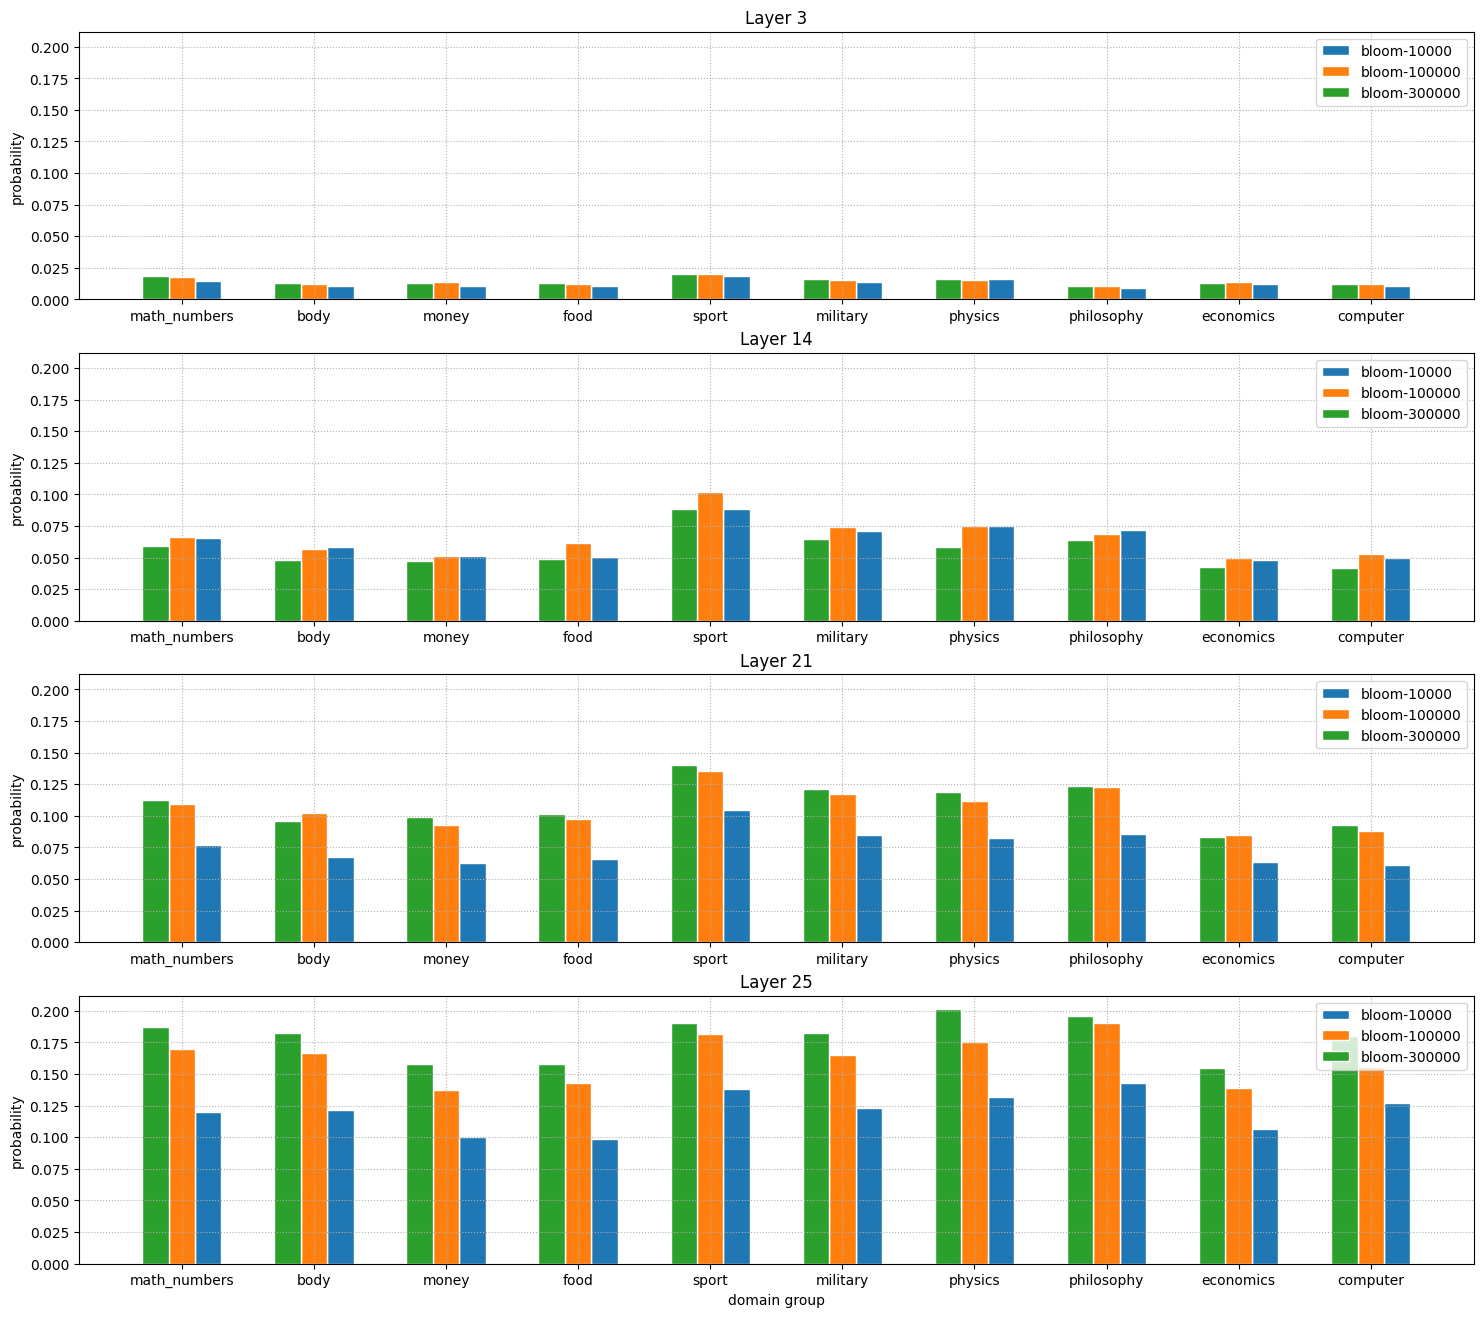

In [89]:
layer_model_results = defaultdict(lambda: defaultdict(list))
x = []

for name in names:
    for domain_group in domain_words:
        if domain_group not in x:
            x.append(domain_group)
        domain_specific_results = model_results[name][domain_group]
        for i, layer in enumerate(layers):
#             if '600' in name:
#                 domain_specific_results[i] = 1 - domain_specific_results[i]
            layer_model_results[layer][name].append(domain_specific_results[i])
    

x_axis = np.arange(len(x))

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18, 16), sharey='all')

for i, layer in enumerate(layers):
    ax = axes.ravel()[i]
    plt.title(f'layer {layer} domain groups difficulty')
    
    for j, (k, v) in enumerate(layer_model_results[layer].items()):
        if '600' in k:
            continue
        ax.bar(x_axis + 0.2 * (1 - j), v, 0.2, label=k, edgecolor="white")
    
    ax.set_title(f'Layer {layer}')
    ax.set_xticks(x_axis, x)
    ax.set_ylabel('probability')
    ax.legend(loc='best')
    ax.grid(ls=':')
    
ax.set_xlabel('domain group')
plt.show()

In [90]:
general_words_dict = {
    'prepositions': ['to', 'in', 'at', 'on', 'out', 'between', 'before', 'after', 'for'],
    'verbs': ['is', 'make', 'has', 'do', 'say', 'get', 'make', 'go', 'take', 'want', 'come', 'kill'],
    'nouns': ['time', 'person', 'year', 'way', 'thing', 'building', 'man', 'group', 'state', 'cat'],
    'adjectives': ['stable', 'good', 'accurate', 'busy', 'clear', 'new', 'long', 'little', 'last'],
    'adverbs': ['completely', 'fully', 'often', 'rarely', 'outside', 'quickly', 'late'],
    'pronouns': ['i', 'me', 'my', 'he', 'she', 'it', 'his', 'her', 'they', 'their', 'you', 'yours']
}
model_results = defaultdict(dict) 
for name, stats in zip(['bloom-100000', 'bloom-300000', 'bloom-600000', 'bloom-10000'], 
                        [word_stats_100000, word_stats_300000, word_stats_600000, word_stats_10000]):
    for domain_group, words in general_words_dict.items():
        word_means = np.zeros(4)
        counter = 0
        for word in words:
            if word not in stats:
                continue
            word_stats = stats[word]
            to_draw = np.array([np.mean(np.nan_to_num(layer_stat)) for layer_stat in word_stats.values()])
            counter += 1
            word_means += to_draw
        if counter < 5:
            print(f'{domain_group} is poorly present, skip...')
            continue
        
        word_means = word_means / counter
        model_results[name][domain_group] = word_means

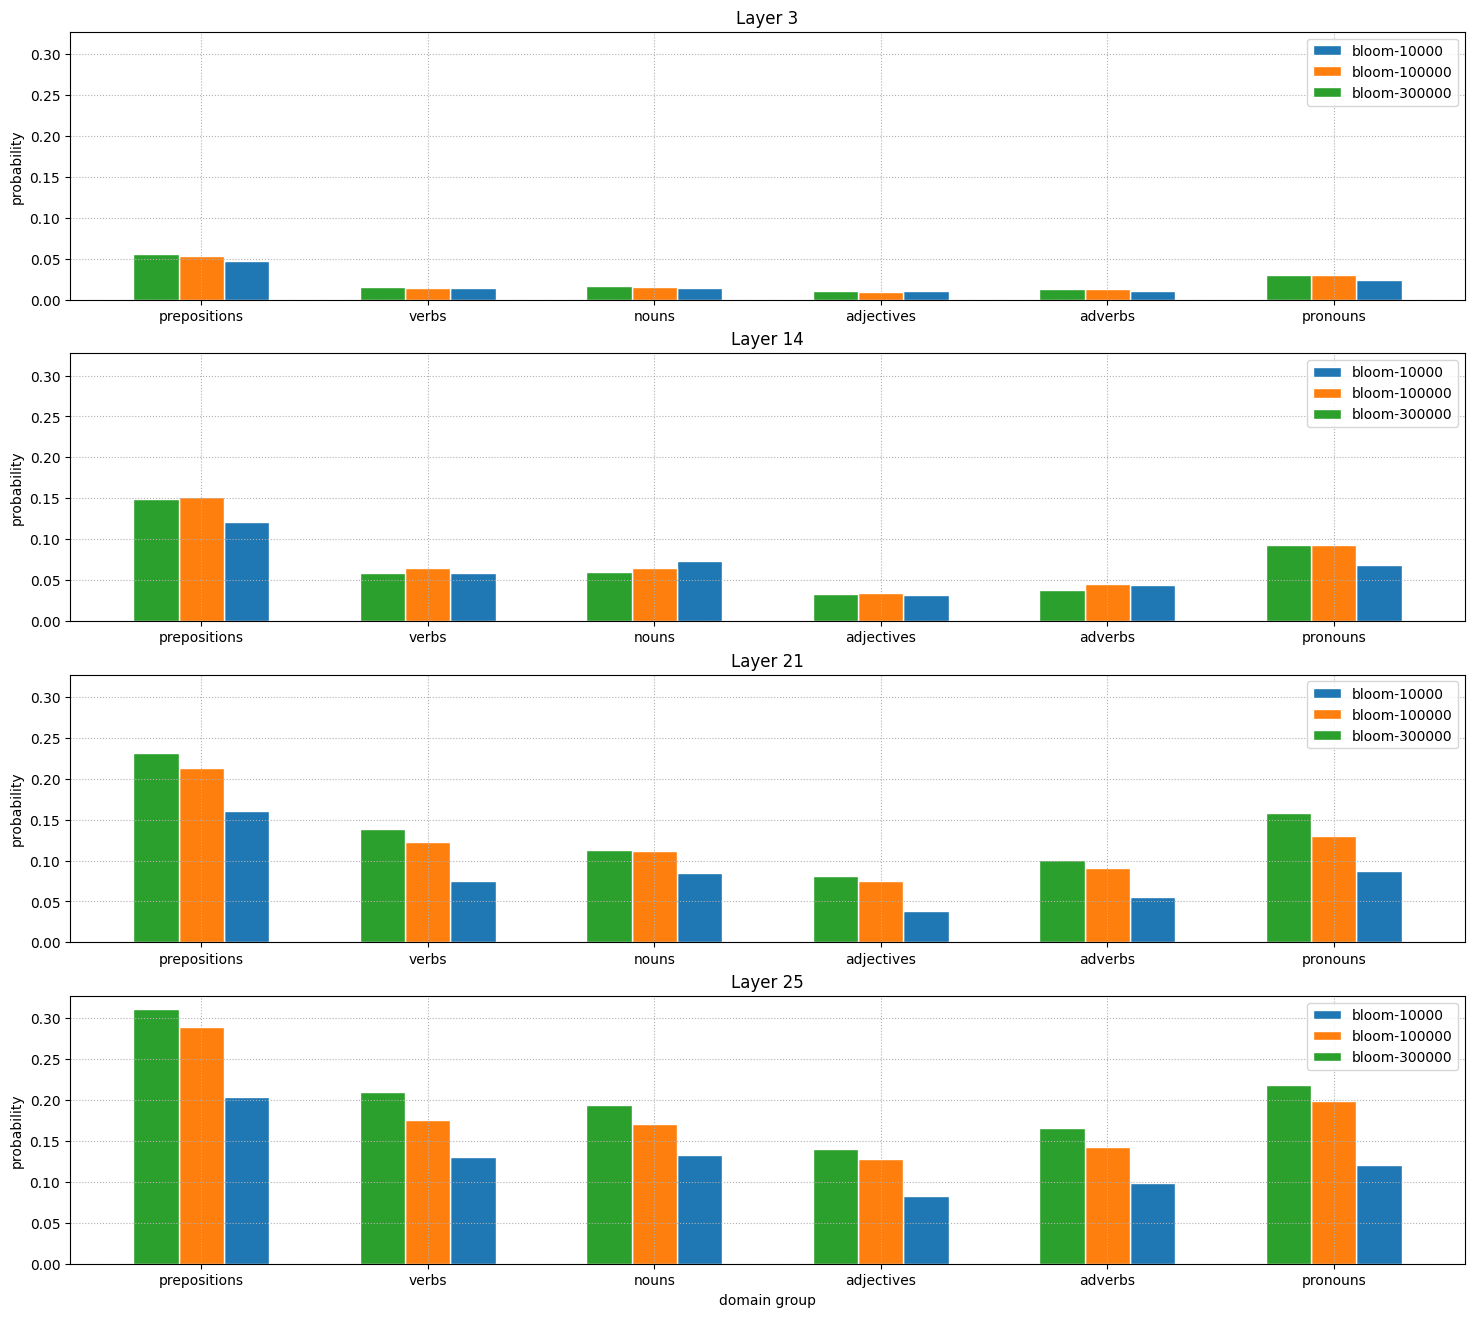

In [91]:
layer_model_results = defaultdict(lambda: defaultdict(list))
x = []
for name in names:
    for domain_group in general_words_dict:
        if domain_group not in x:
            x.append(domain_group)
        domain_specific_results = model_results[name][domain_group]
        for i, layer in enumerate(layers):
            layer_model_results[layer][name].append(domain_specific_results[i])
    

x_axis = np.arange(len(x))

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18, 16), sharey='all')

for i, layer in enumerate(layers):
    ax = axes.ravel()[i]
    plt.title(f'layer {layer} domain groups difficulty')
    
    for j, (k, v) in enumerate(layer_model_results[layer].items()):
        if '600' in k: 
            continue
        ax.bar(x_axis + 0.2 * (1 - j), v, 0.2, label=k, edgecolor="white")
    
    ax.set_title(f'Layer {layer}')
    ax.set_xticks(x_axis, x)
    ax.set_ylabel('probability')
    ax.legend(loc='upper right')
    ax.grid(ls=':')
    
ax.set_xlabel('domain group')
plt.show()

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams

def plot_box(word, word_stats, model_checkpoint):
    probs, layer_num = [], []
    for i, layer in enumerate(layers):
        for prob in word_stats[word][i]:
            if prob is not None:
                probs.append(prob)
                layer_num.append(layer)
                
    data = pd.DataFrame({'probs': probs, 'layer': layer_num})
    plt.figure(figsize=(10, 10))
    plt.title(word + ' ' + model_checkpoint)
    sns.boxplot(x='probs', y='layer', data=data, orient='h')
    plt.show()

In [ ]:
general_words_dict

In [ ]:
plot_box('do', word_stats_10000, '10000 checkpoint')

In [ ]:
plot_box('do', word_stats_300000, '300000 checkpoint')

In [25]:
layer_indices = [3, 14, 21, 25]


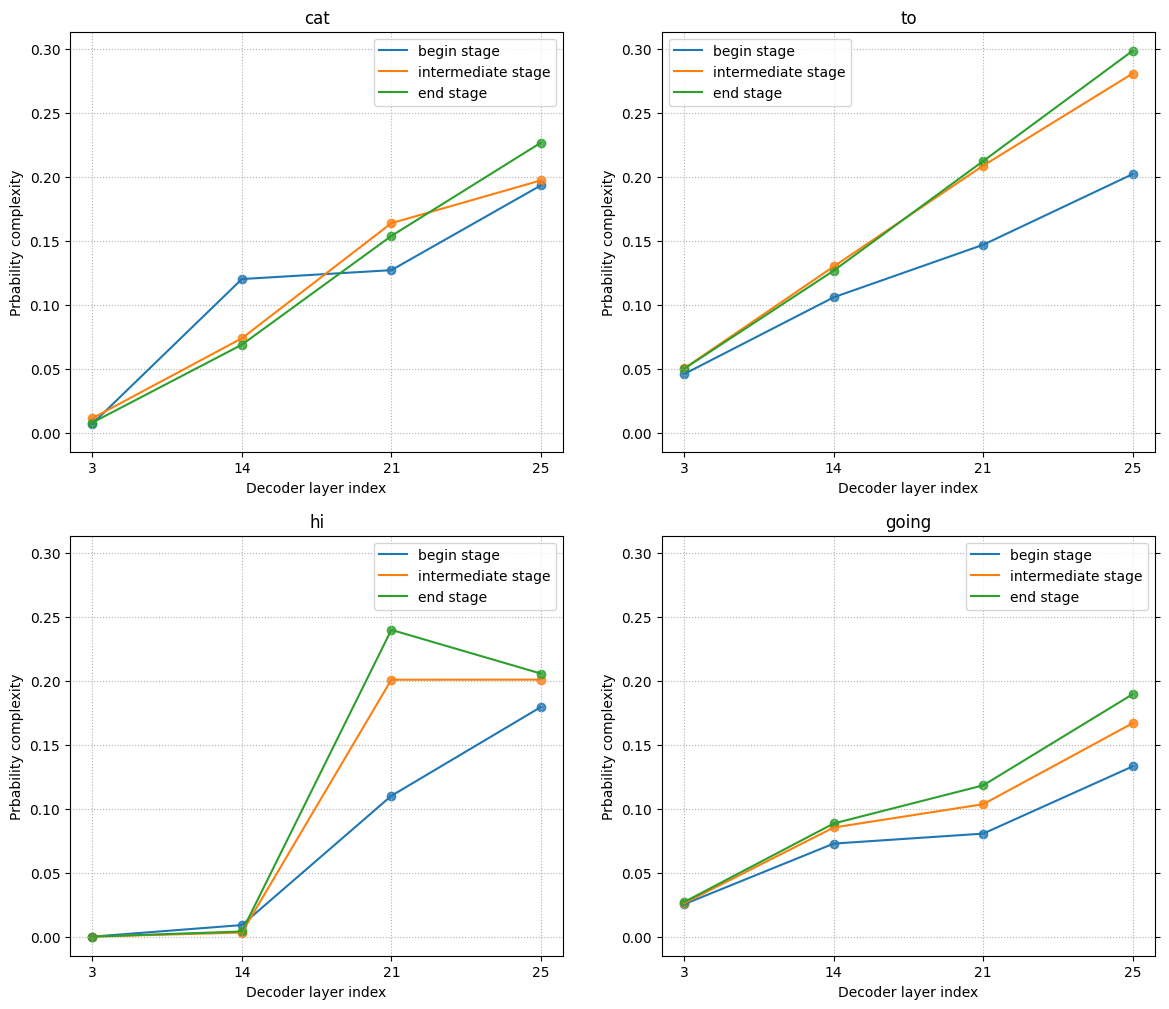

In [39]:
import joblib

# word_stats = joblib.load('files/word_stats_dict.joblib')

import matplotlib.pyplot as plt

import numpy as np

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12), sharey='all')

for word, ax in zip(['cat', 'to', 'hi', 'going'], axes.ravel()):
    
    for word_stats, name in zip([word_stats_10000, word_stats_100000, word_stats_300000],
                                ['begin stage', 'intermediate stage', 'end stage']):
        
        stats = word_stats[word]

        to_draw = [np.mean(np.nan_to_num(layer_stat)) for layer_stat in stats.values()]
        ax.plot(np.arange(len(stats)), to_draw, label=name)
        ax.scatter(np.arange(len(stats)), to_draw, alpha=0.8)

    ax.legend()
    ax.set_xticks(np.arange(len(to_draw)), layer_indices)
    ax.set_title(word)
    ax.set_xlabel('Decoder layer index')
    ax.set_ylabel('Prbability complexity')
    if word in ['to', 'going']:
        ax.tick_params('y', reset=True)
    ax.grid(ls=':')

plt.show()

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams

def plot_box(word, word_stats):
    probs, layer = [], []
    for i, layer in enumerate(layers):
        for prob in word_stats[word][i]:
            if prob is not None:
                probs.append(prob)
                layer.append(i)
                
    data = pd.DataFrame({'probs': probs, 'layer': layer})
    plt.figure(figsize=(10, 10))
    plt.title(word)
    sns.boxplot(x='probs', y='layer', data=data, orient='h')
    plt.show()

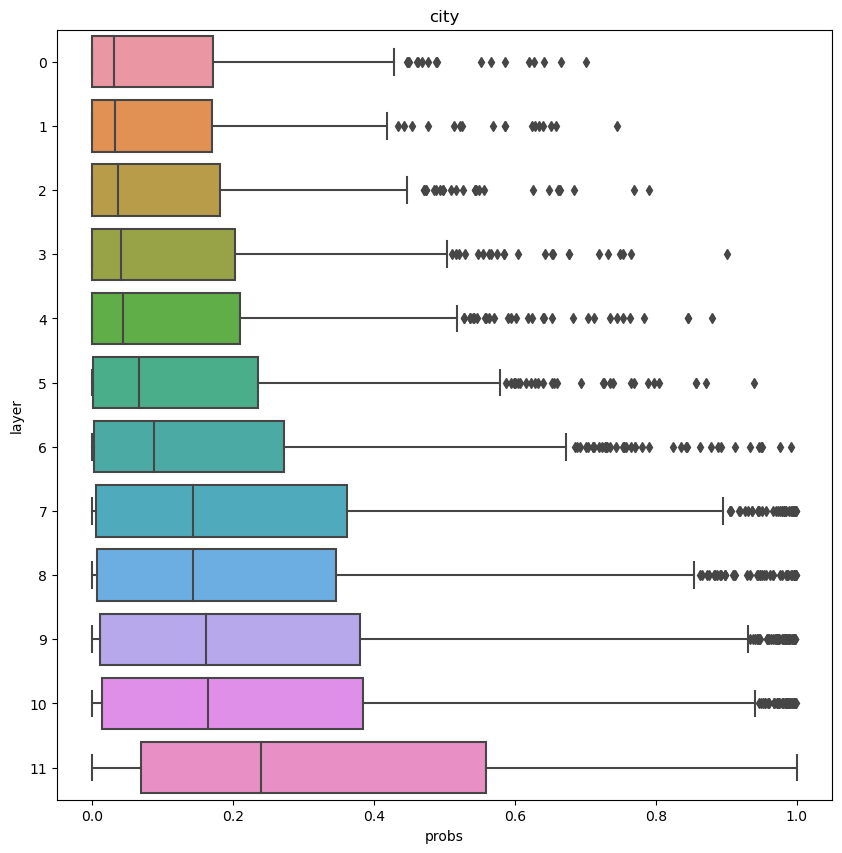

In [54]:
plot_box('city')

In [ ]:
5 слоев << 5 cлоев обрезанной 12

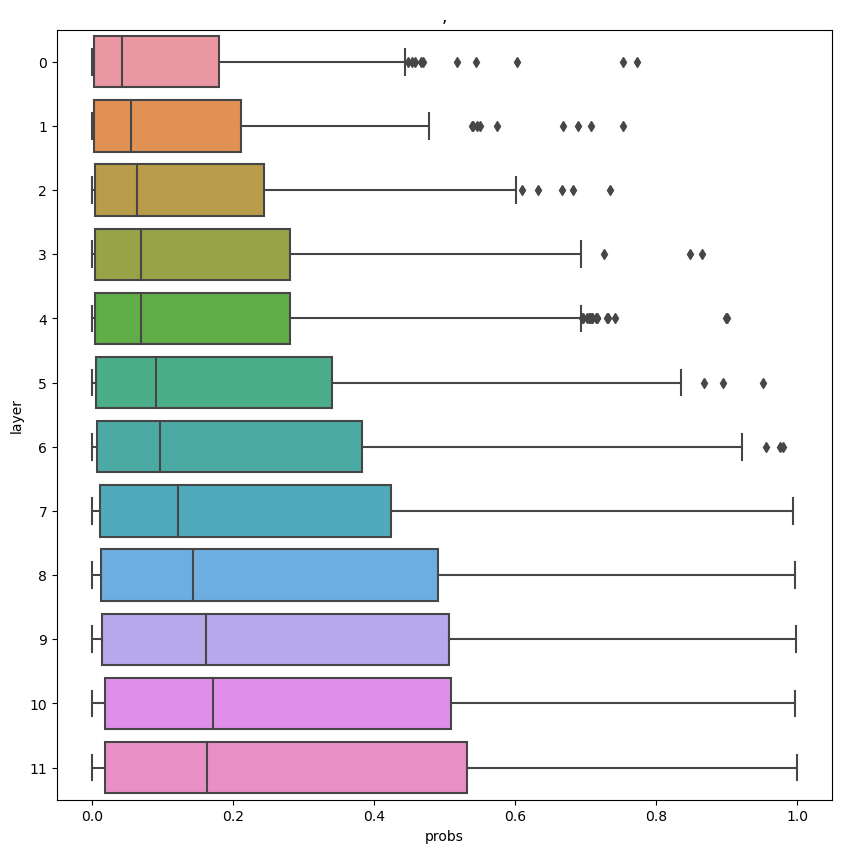

In [59]:
plot_box(',')

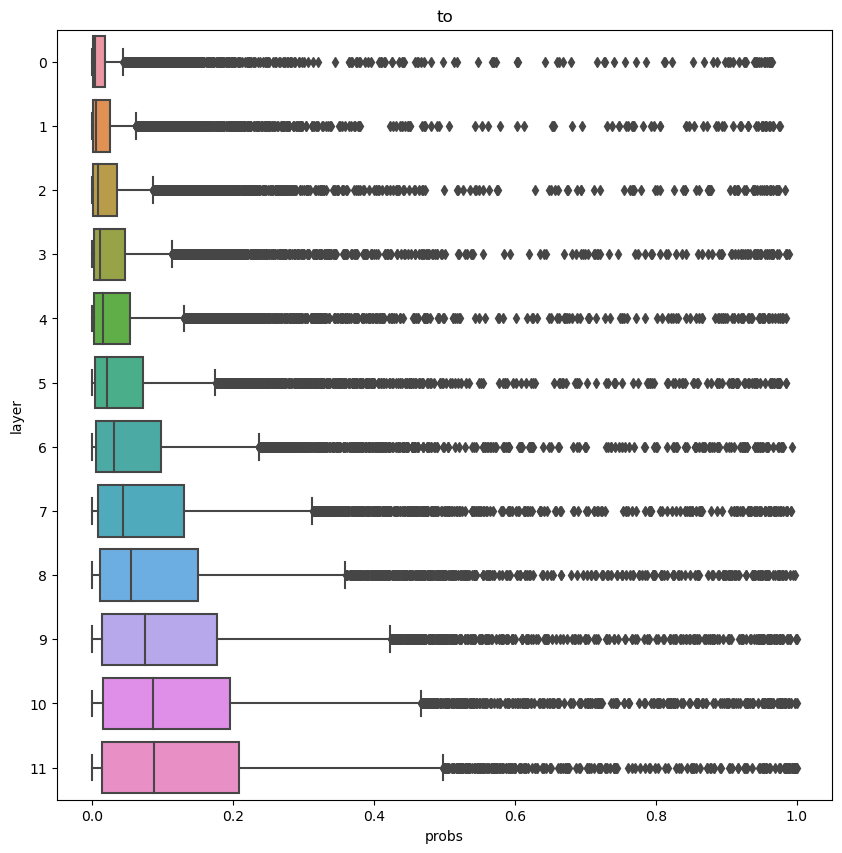

In [61]:
plot_box('to')

In [71]:
word_stats['gender']

{0: [0.08238239586353302,
  0.0006806437741033733,
  0.000738027214538306,
  0.000902646454051137,
  0.001476115663535893,
  0.028343884274363518,
  0.08056169003248215,
  0.030315384910302612,
  0.0856398971557913,
  1.2861842151323799e-05,
  0.0010929853888228536,
  0.000936208525672555,
  0.08673879504203796,
  0.09511014074087143,
  1.3362458048504777e-05,
  0.02110379934310913,
  0.015644513070583344,
  0.10427895188331604,
  0.07436335320484691,
  0.0008415169431827962,
  0.0009420481510460377,
  0.09380535781383514,
  0.00040490159881301224,
  0.1027795746922493,
  0.049206458032131195,
  7.772538810968399e-05,
  0.1901107281446457,
  0.007686324883252382,
  0.4925767183303833,
  0.0008689993410371244,
  0.015810757875442505,
  0.07070982456207275,
  1.2958790875927662e-06,
  0.006524617318063974],
 1: [0.09552838653326035,
  0.0006915595731697977,
  0.00036631114198826253,
  0.0004488227132242173,
  0.0028232529293745756,
  0.04948309436440468,
  0.11149359587579966,
  0.063436

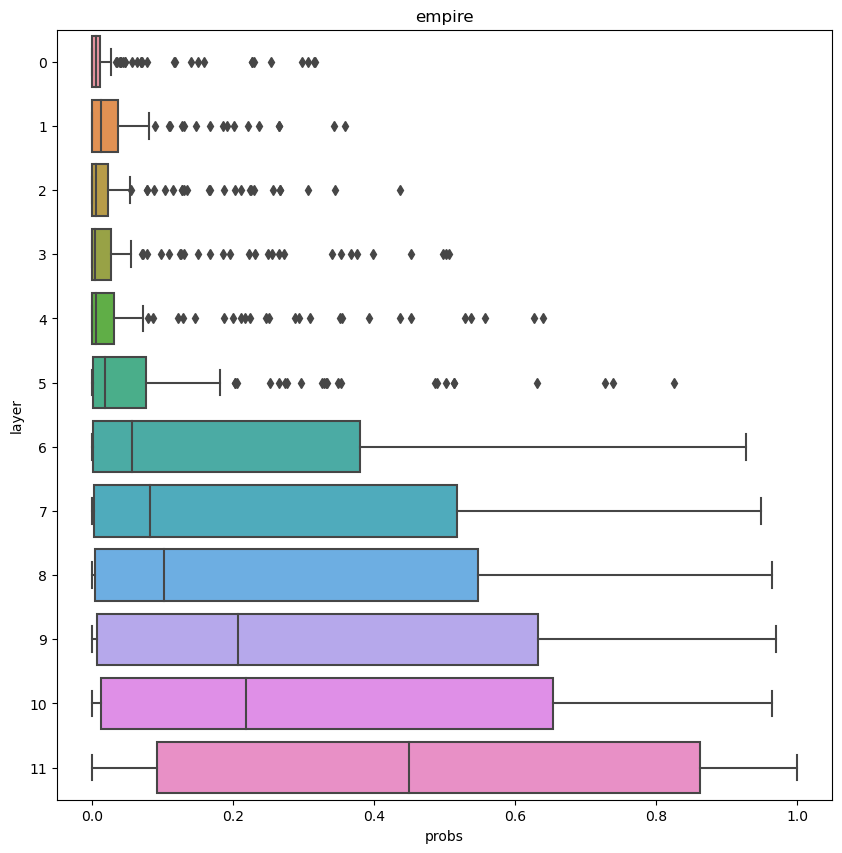

In [76]:
plot_box('empire')

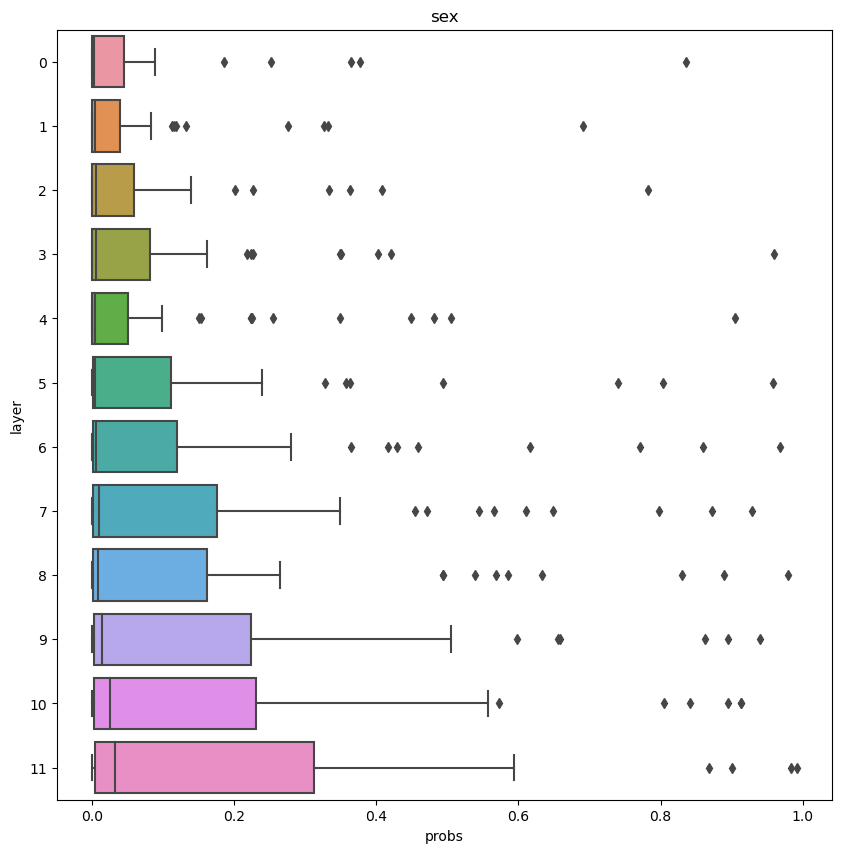

In [72]:
plot_box('sex')

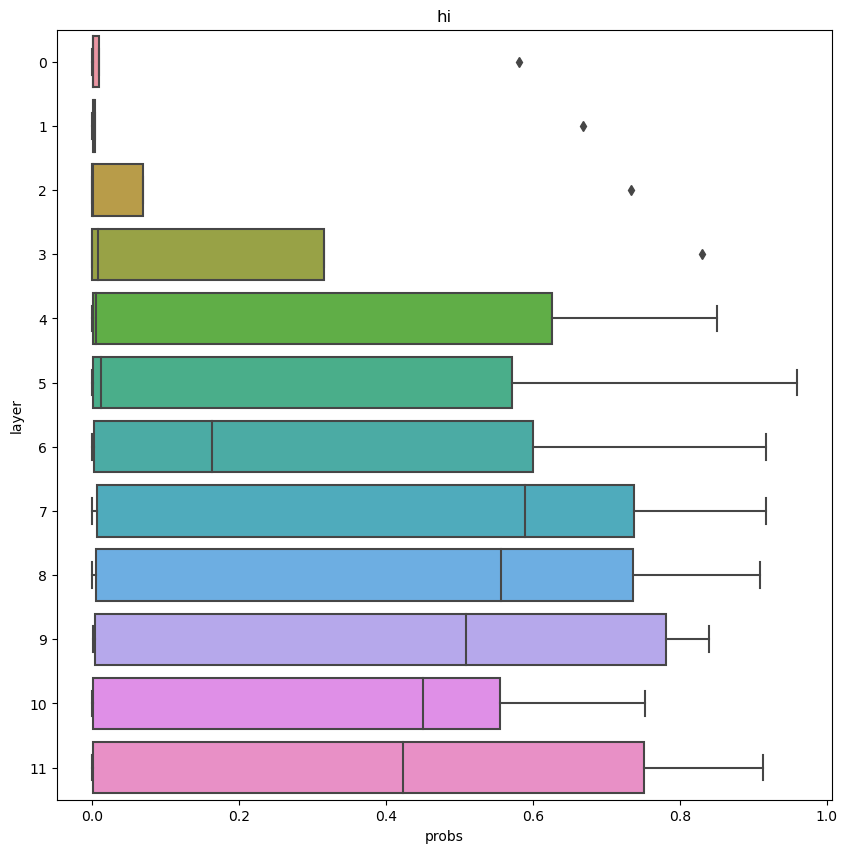

In [56]:
plot_box('hi')

In [ ]:
plot_box('hi')

### Смотрим вероятности модели

In [37]:
def mean_prob_for_layer(layer, count_th=1):

    all_probs = 0
    all_words = 0

    for k in word_stats:
        if len(word_stats[k][11]) > count_th: 
            all_probs += sum(np.nan_to_num(word_stats[k][layer]))
            all_words += len(np.nan_to_num(word_stats[k][layer]))
    
    return all_probs / all_words

layer = 11

for layer in range(12):
    print(f'Средняя вероятность c которой GPT предсказывает слово на слое {layer + 1}:', mean_prob_for_layer(layer))

Средняя вероятность c которой GPT предсказывает слово на слое 1: 0.058293671960873074
Средняя вероятность c которой GPT предсказывает слово на слое 2: 0.06698115316835129
Средняя вероятность c которой GPT предсказывает слово на слое 3: 0.07957913408228258
Средняя вероятность c которой GPT предсказывает слово на слое 4: 0.09248956066812457
Средняя вероятность c которой GPT предсказывает слово на слое 5: 0.0986690154813798
Средняя вероятность c которой GPT предсказывает слово на слое 6: 0.11897564885838861
Средняя вероятность c которой GPT предсказывает слово на слое 7: 0.13637503260212663
Средняя вероятность c которой GPT предсказывает слово на слое 8: 0.1599089279140091
Средняя вероятность c которой GPT предсказывает слово на слое 9: 0.17230394082216186
Средняя вероятность c которой GPT предсказывает слово на слое 10: 0.18926150078263654
Средняя вероятность c которой GPT предсказывает слово на слое 11: 0.1992108818981764
Средняя вероятность c которой GPT предсказывает слово на слое 12:

Посмотрим для часто встречающихся слов

In [38]:
for layer in range(12):
    print(f'Средняя вероятность c которой GPT предсказывает слово на слое {layer + 1}:', mean_prob_for_layer(layer, 50))

Средняя вероятность c которой GPT предсказывает слово на слое 1: 0.06299346585089008
Средняя вероятность c которой GPT предсказывает слово на слое 2: 0.07258940107846186
Средняя вероятность c которой GPT предсказывает слово на слое 3: 0.08587495447784149
Средняя вероятность c которой GPT предсказывает слово на слое 4: 0.09950223178208592
Средняя вероятность c которой GPT предсказывает слово на слое 5: 0.1057818123715835
Средняя вероятность c которой GPT предсказывает слово на слое 6: 0.12602385471660965
Средняя вероятность c которой GPT предсказывает слово на слое 7: 0.14359573494286423
Средняя вероятность c которой GPT предсказывает слово на слое 8: 0.1672411716502503
Средняя вероятность c которой GPT предсказывает слово на слое 9: 0.17927050058394506
Средняя вероятность c которой GPT предсказывает слово на слое 10: 0.1957206843962703
Средняя вероятность c которой GPT предсказывает слово на слое 11: 0.2050413126082107
Средняя вероятность c которой GPT предсказывает слово на слое 12: 0

Видим, что она не сильно отличается от усреднения по всем токенам

In [48]:
mean_probs = {k: {l: np.mean(np.nan_to_num(word_stats[k][l])) for l in word_stats[k]} for k in word_stats}

In [51]:
word = 'president'

def print_word_by_layer_stat(word):
    for layer in range(12):
        print(
            f'Средняя вероятность предсказать слово {word} на слое {layer + 1}:', 
            mean_probs[word][layer],
        )

In [52]:
word = 'president'
print_word_by_layer_stat(word)

Средняя вероятность предсказать слово president на слое 1: 0.09713721097490159
Средняя вероятность предсказать слово president на слое 2: 0.10641415556260855
Средняя вероятность предсказать слово president на слое 3: 0.11982719386238055
Средняя вероятность предсказать слово president на слое 4: 0.1348904199566825
Средняя вероятность предсказать слово president на слое 5: 0.1400588304762486
Средняя вероятность предсказать слово president на слое 6: 0.16361451941259345
Средняя вероятность предсказать слово president на слое 7: 0.17842379961325713
Средняя вероятность предсказать слово president на слое 8: 0.20288914464895588
Средняя вероятность предсказать слово president на слое 9: 0.21091215355460688
Средняя вероятность предсказать слово president на слое 10: 0.22472528944668999
Средняя вероятность предсказать слово president на слое 11: 0.2309144530621909
Средняя вероятность предсказать слово president на слое 12: 0.23620452363475727


In [ ]:
word = 'cat'
print_word_by_layer_stat(word)

____

In [ ]:
# head_outputs[i][bs][seqlen][tok_num] = P(из i-го слоя на seqlen месте стоит токен tok_num) -- как у нас щас
# пример: хотим взять для 5го токена градиенты из первой головы
 
head_outputs = model(**tokenized_input)['head_outputs']
 
# готовим вероятности
ho = heads_output[1]
token_probs = ho[:, 5 - 1] # предсказание для этого токена
token = tokenized_input['input_ids'][:, 5] # само значение токена
 
loss_fn = torch.nn.CrossEntropyLoss()
 
loss = loss_fn(token_probs, token, )
 
optimizer = torch.optim.Adam(model.parameters())
optimizer.zero_grad()
loss.backward()
 
for param_name, param in model.named_parameters():
    print(f'gradient for {param_name} =', param.grad)



In [ ]:
# полезно брать норму градиентов и сравнивать ее с большой / маленькой
total_norm = 0
for p in model.parameters():
    param_norm = p.grad.data.norm(2)
    total_norm += param_norm.item() ** 2
total_norm = total_norm ** (1. / 2)
 